#### TODO:
- Algo seems to only be off by $100, but that's not much in the crypto world.
- Need to figure out how to make this more useful. 
- Next price point isn't bad, but what's the start? I can make a decent model. Now what?
    - Figure out how to generate the same data, but now estimate it for the next day.

# Use lagged values to predict current price to forecast price
- Notes from this video: https://www.youtube.com/watch?v=xaIA83x5Icg
 - Create separate transformers for features on different scales
 - Use this video for building an initial LSTM model
- Use this video and it's subsequent one for time series forecasting for BTC using binance exchange data: https://www.youtube.com/watch?v=jR0phoeXjrc
    - Use shift to push a column down for matching previous data points to a forecasted point.
    - This video is showing how to prep data for a time series model.
    - This video is for how to take that preprocessed data and put into PyTorch for the LSTM model: https://www.youtube.com/watch?v=ODEGJ_kh2aA&t=107s
         - 

### TODO:
- Now, it shows a broad trend, but there's just nothing going on? Both indicate a lull right now. 
- Need to pull in the hourly data, to show if there's more variation.

Use this to get data for non-daily estimations: https://www.cryptodatadownload.com/data/bitstamp/

In [3719]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import os

In [3720]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

In [3721]:
import datetime

In [3722]:
import tensorflow as tf
from keras import layers

In [3723]:
from keras import models

In [3724]:
from keras import optimizers

In [3725]:
import tqdm

In [3751]:
test = pd.read_csv('Bitstamp_BTCUSD_1h.csv')

In [3726]:
def train_models(df, label,training_cols, time_steps):
    scaler = StandardScaler()
#     df[label] = scaler.fit_transform(df[[label]])
#     for col in training_cols:
#         df[col] = scaler.transform(df[[col]])
    X = df[training_cols].values
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    output = compare_rg(X_train, y_train, X_test, y_test, time_steps)
    return output, scaler

In [3727]:
def compare_rg(X_train, y_train, X_test, y_test, time_steps):
    classifiers = {
        'XGBR': XGBRegressor(),
#         'NN': neural_net(X_train.shape, time_steps)
    }

    outputs = {
        'XGBR': [],
#         'NN': []
    }
    for model in classifiers:
        if model == 'NN':            
            algo = classifiers[model]
            X_train, y_train = create_dataset(X_train, y_train, time_steps)
            X_test, y_test = create_dataset(X_test, y_test, time_steps)
            algo.fit(X_train, y_train, X_test, y_test)
        else:
            algo = classifiers[model]
            algo.fit(X_train, y_train)
            y_predict = algo.predict(X_test)
#             print(" ")
#             print(model, ': ',mse(y_test, y_predict))
        for output in outputs:
            if output == model:
                outputs[output] = algo
#         print('')
    return outputs

In [3728]:
#https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/
# https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
class neural_net:
    def __init__(self, shape_input, time_steps):
        self.shape_input = shape_input
        self.model = models.Sequential()
        self.batch_size = 32
        self.model.add(layers.Bidirectional(
            layers.LSTM(units=8, input_shape=(time_steps, shape_input[1]), return_sequences=False)
        ))
        self.model.add(layers.Dropout(0.2, name='dropout_0'))
        self.model.add(layers.Dense(4, activation='relu'))
        self.model.add(layers.Dense(1, activation='relu'))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
#         print(self.model.summary())

    
    def fit(self, X_train, y_train, X_test, y_test):
        self.model.fit(x=X_train, y=y_train, batch_size = self.batch_size, epochs=50, shuffle=False, validation_split=0.1)
        evaluation = self.model.evaluate(X_test, y_test)
        print(evaluation)
    
    def predict(self, Xnew):
        yNew = self.model.predict_classes(Xnew)
        return yNew

In [3729]:
def create_dataset(X, y, time_steps = 20):
    y = y.values
    Xs, ys = [] , []
    for i in range(len(X) - time_steps):
        v = X[i: (i+time_steps)]
        Xs.append(v)
        ys.append(y[(i+time_steps)])
    return np.array(Xs), np.array(ys)

In [3730]:
future_estim_START = 1
future_estim_STOP = 7

NUM_MODELS = 100

window_size = 20

graph_timespan = 50

In [3731]:
crypto = pd.read_csv('BTC-USD.csv')

In [3732]:
for col in crypto.columns.values:
    crypto.rename(columns={
        col: col.lower()
    }, inplace=True)
    
ma = []
upper = []
lower = []
for i in range(window_size):
    ma.append(np.nan)
    upper.append(np.nan)
    lower.append(np.nan)
for row in crypto.iterrows():
    if row[0] < window_size:
        continue
#     print(row[0])
    mean = np.mean(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    ma.append(mean)
    std = np.std(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    upper.append((mean+std*2))
    lower.append((mean-std*2)) 

crypto['ma20'] = ma
crypto['upper'] = upper
crypto['lower'] = lower

training_cols = []
for col in crypto.columns.values:
    if 'next' not in col and 'date' not in col and 'adj' not in col:
        training_cols.append(col)

crypto.drop('adj close',axis=1, inplace=True)

In [3733]:
og_crypto = crypto.copy()

In [3734]:
future_estimations = {}
for future_estim in tqdm.trange(future_estim_START, future_estim_STOP+1):
    
#     print('Future Estim: ', str(future_estim))
    
    output_label = 'next_close_'+str(future_estim)

    crypto[output_label] = crypto['close'].shift(-1*future_estim)

    temp_og_crypto = crypto.copy()
    
    models = []
    for i in range(NUM_MODELS):
        crypto = temp_og_crypto.copy()
        crypto.dropna(inplace=True)
        output, scaler = train_models(crypto, output_label,training_cols, window_size)
        models.append(output['XGBR'])

    crypto = og_crypto.copy()

    predict_cols = []
    for i in range(NUM_MODELS):
        col_name = 'predicted_close'+str(i)
        crypto[col_name] = models[i].predict(crypto[training_cols].values)
        predict_cols.append(col_name)

    future_estimations.update({'predicted_close_'+str(future_estim) : crypto[predict_cols].mean(axis=1)})
    
    for col in temp_og_crypto.columns.values:
        og_crypto[col] = temp_og_crypto[col]
#     print('Cols:', og_crypto.columns.values)
#     print(og_crypto.shape)

100%|██████████| 7/7 [02:21<00:00, 20.26s/it]


In [3735]:
crypto = og_crypto.copy()

In [3736]:
crypto.drop(predict_cols, axis=1, inplace=True)

In [3737]:
for i in range(future_estim):
    crypto = crypto.append({'date': np.nan}, ignore_index=True)

In [3738]:
dates = []
for date in crypto['date']:
    if not isinstance(date, str):
        if date is np.nan:
            prev_date += datetime.timedelta(days=1)
            dates.append(prev_date)
        else:
            dates.append(date)
            prev_date = date
    else:
        if date is np.nan:
            prev_date += datetime.timedelta(days=1)
            dates.append(prev_date)
        else:
            date_list = date.split('-')
            date = datetime.datetime(year=int(date_list[0]), month=int(date_list[1]), day=int(date_list[2]))
            dates.append(date)
            prev_date = date

In [3739]:
crypto['date'] = dates

In [3740]:
crypto.dropna(subset=['date'], inplace=True)

In [3741]:
for estim in future_estimations:
    crypto[estim] = future_estimations[estim]

In [3742]:
next_cols = []
for col in crypto.columns.values:
    if 'next' in col:
        next_cols.append(col)

In [3743]:
for col in next_cols:
    future_estim = int(col.split('_')[-1])
    crypto['next_close_'+str(future_estim)] = crypto['next_close_'+str(future_estim)].shift(future_estim)
    crypto['predicted_close_'+str(future_estim)] = crypto['predicted_close_'+str(future_estim)].shift(future_estim)

In [3744]:
predict_cols = []
for col in crypto.columns.values:
    if 'predicted' in col:
        predict_cols.append(col)

In [3745]:
crypto = crypto.tail(graph_timespan)

In [3746]:
plot_estims = {}
for col in predict_cols:
    plot_estims.update({col: crypto[col].tolist()})

In [3747]:
y_true = crypto['close'].tolist()
y_ma = crypto['ma20'].tolist()
y_upper = crypto['upper'].tolist()
y_lower = crypto['lower'].tolist()
x = crypto['date'].tolist()

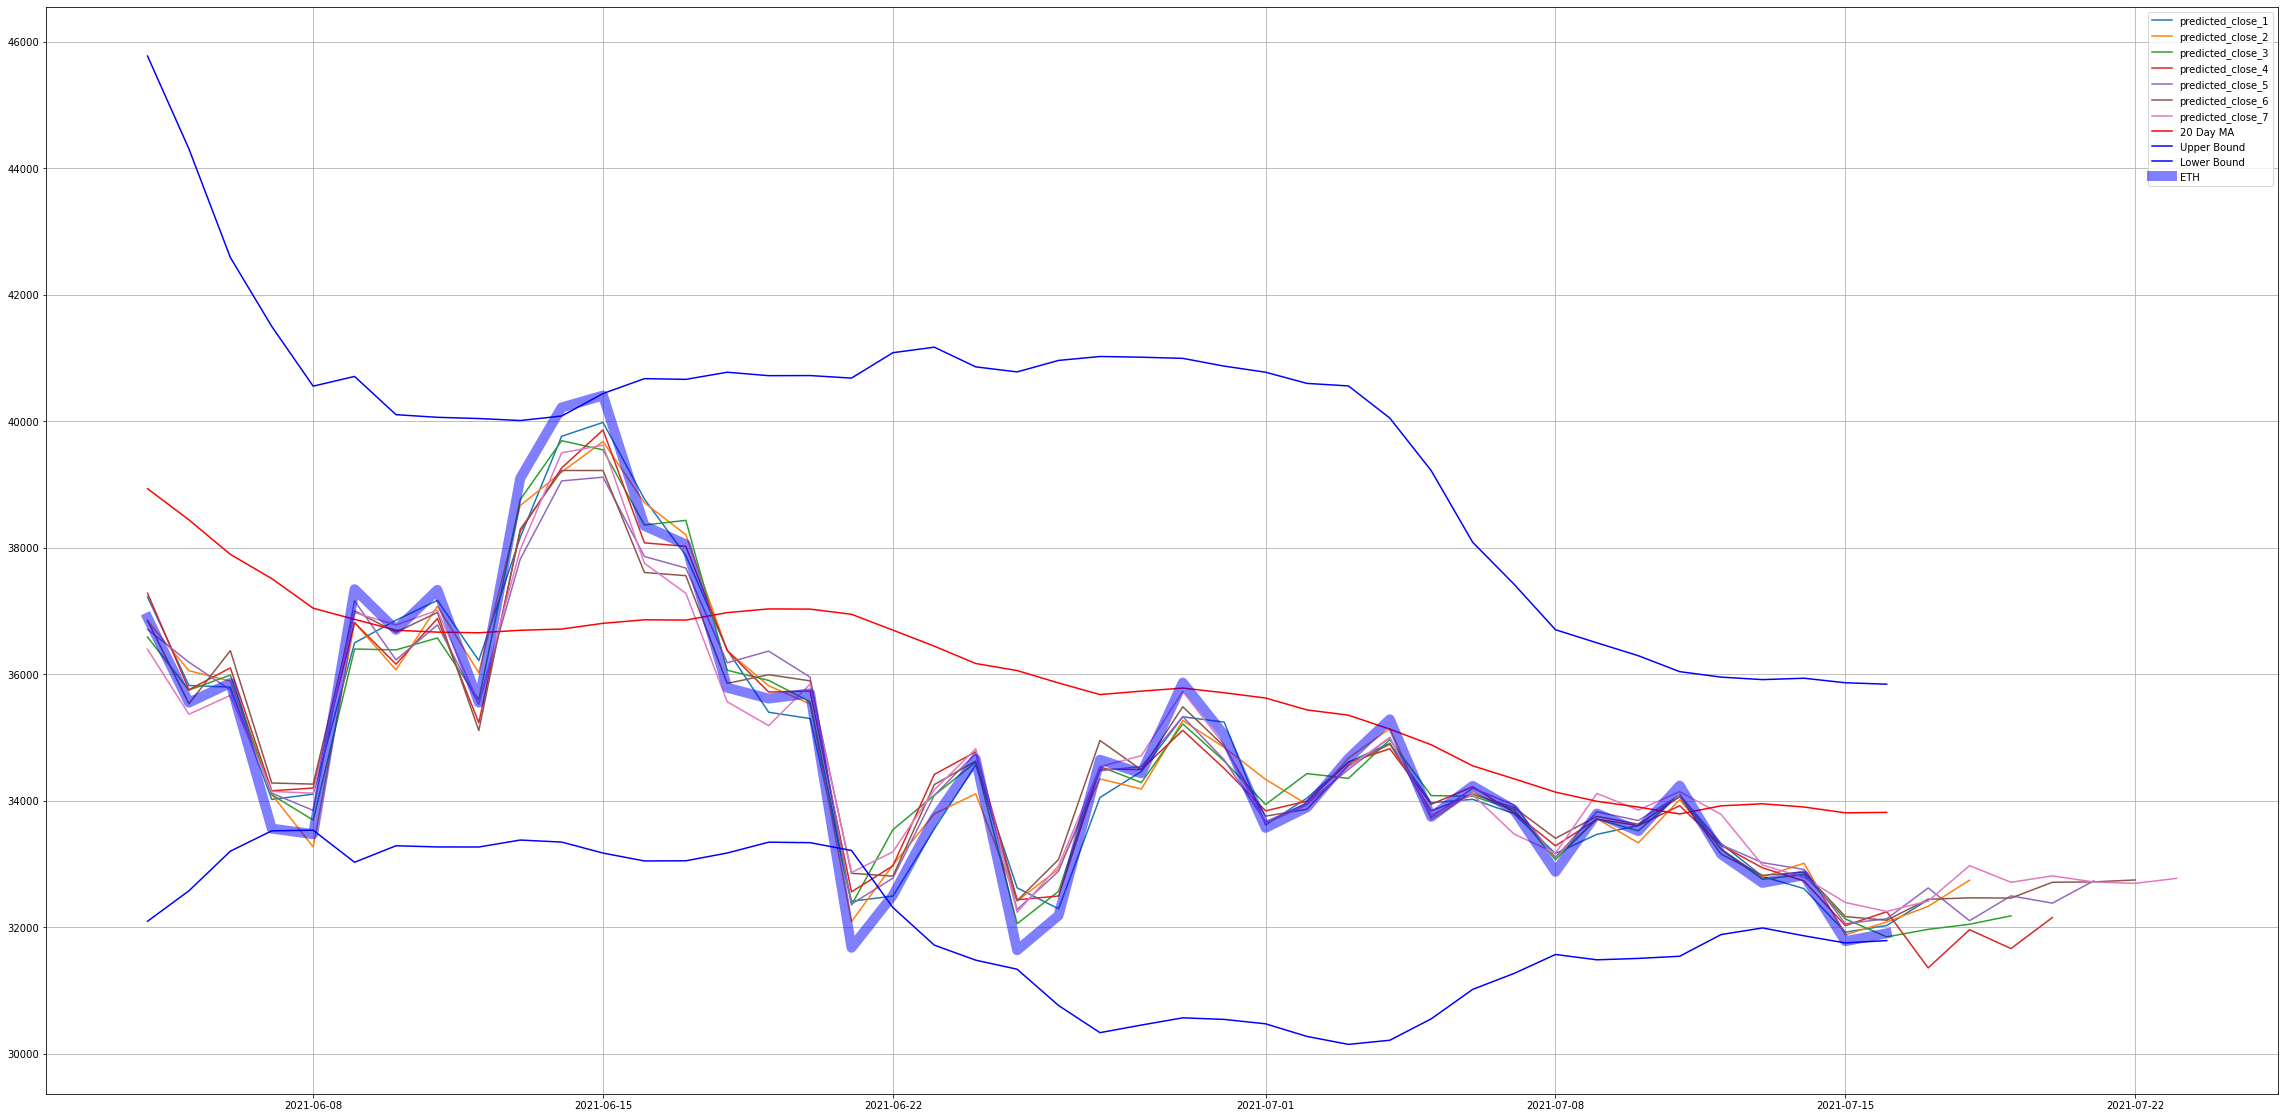

In [3748]:
fig = plt.figure(figsize=(40,20))
for estim in plot_estims:
    plt.plot(x, plot_estims[estim], label=estim)
plt.plot(x, y_ma, label='20 Day MA', color='r')
plt.plot(x, y_upper, label='Upper Bound', color='b')
plt.plot(x, y_lower, label='Lower Bound', color='b')
plt.plot(x, y_true, label='ETH', linewidth=10, color='b', alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

In [3749]:
crypto[predict_cols].tail()

,predicted_close_1,predicted_close_2,predicted_close_3,predicted_close_4,predicted_close_5,predicted_close_6,predicted_close_7
1829,NaN,NaN,32181.328125,31664.363281,32497.185547,32462.150391,32711.265625
1830,NaN,NaN,NaN,32154.775391,32382.152344,32712.197266,32813.261719
1831,NaN,NaN,NaN,NaN,32734.802734,32717.998047,32716.105469
1832,NaN,NaN,NaN,NaN,NaN,32748.679688,32695.007812
1833,NaN,NaN,NaN,NaN,NaN,NaN,32773.765625


In [3750]:
# crypto.to_excel('ETH-USD_forecast_from_'+str(datetime.datetime.today()).split(' ')[0]+'.xlsx')